In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from utils.helpers import int2atom, atom2int
import seaborn as sn
from tqdm import tqdm
import dask.dataframe as dd
import dask
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44926 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 270.21 GB


In [3]:
%matplotlib notebook

In [ ]:
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")

df = dd.read_sql_table('results','sqlite:////work1/s180213/results_zinc_3.db', index_col='model_id')

/zhome/9e/8/130993/.local/lib/python3.6/site-packages/sqlalchemy/sql/sqltypes.py:666: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  "storage." % (dialect.name, dialect.driver)


In [3]:
df= dd.read_parquet('/work1/s180213/zinc_parquet/data.parquet')

In [9]:

f1_mask = df \
                .groupby(['num_masks','model_id', 'model_name_short']) \
                .apply(lambda df:pd.Series({
                    'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                    'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                    'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                    'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                    }
                    )
                 ) \
                .groupby(['model_name_short','num_masks']) \
                .agg(['mean','std'])



f1_length = df[df['num_masks']==1]\
                    .groupby(['model_id', 'model_name_short','length']) \
                    .apply(lambda df:pd.Series({
                    'f1 micro':f1_score(df.target, df.prediction, average='micro'),
                    'f1 macro':f1_score(df.target, df.prediction, average='macro'),
                    'f1 micro (octet)':f1_score(df.target, df.prediction_octet, average='micro'),
                    'f1 macro (octet)':f1_score(df.target, df.prediction_octet, average='macro')
                    }
                    )
                 ) \
                   .groupby(['model_name_short', 'length']).agg(['mean','std'])

model_df = df.groupby(['num_masks','model_id', 'model_name_short']).mean()
model_df['pp'] = np.exp(model_df['cross_entropy'])
model_df = model_df.groupby(['model_name_short', 'num_masks']).agg(['mean','std'])[['accuracy','accuracy_octet','pp']]
model_df

results_mask = dd.concat([f1_mask, model_df],axis=1)

/zhome/9e/8/130993/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  after removing the cwd from sys.path.
/zhome/9e/8/130993/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
/zhome/9e/8/130993/.local/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not 

In [14]:
results_mask = results_mask.compute()
results_mask

f1 micro      f1 macro     f1 micro (octet)      \
                                mean std      mean std             mean std   
model_name_short num_masks                                                    
transformer      1          0.981838 NaN  0.528300 NaN         0.991026 NaN   
                 10         0.975480 NaN  0.516526 NaN         0.984609 NaN   
                 20         0.967412 NaN  0.493648 NaN         0.977947 NaN   
                 30         0.958545 NaN  0.463401 NaN         0.970549 NaN   
                 40         0.950081 NaN  0.429085 NaN         0.963150 NaN   
                 50         0.945343 NaN  0.408793 NaN         0.958665 NaN   
                 60         0.944569 NaN  0.405295 NaN         0.957779 NaN   
                 70         0.944533 NaN  0.405171 NaN         0.957717 NaN   
                 80         0.944946 NaN  0.405308 NaN         0.957982 NaN   

                           f1 macro (octet)      accuracy     accuracy_octet  \
                                       mean std      mean std           mean   
model_name_short num_masks                                                     
transformer      1                 0.877011 NaN  0.981838 NaN       0.991026   
                 10                0.874021 NaN  0.975480 NaN       0.984609   
                 20                0.866134 NaN  0.967412 NaN       0.977947   
                 30                0.857729 NaN  0.958545 NaN       0.970549   
                 40                0.848944 NaN  0.950081 NaN       0.963150   
                 50                0.843737 NaN  0.945343 NaN       0.958665   
                 60                0.842610 NaN  0.944569 NaN       0.957779   
                 70                0.842517 NaN  0.944533 NaN       0.957717   
                 80                0.842573 NaN  0.944946 NaN       0.957982   

                                      pp      
                           std      mean std  
model_name_short num_masks                    
transformer      1         NaN  1.063065 NaN  
                 10        NaN  1.079414 NaN  
                 20        NaN  1.103446 NaN  
                 30        NaN  1.130582 NaN  
                 40        NaN  1.155907 NaN  
                 50        NaN  1.169382 NaN  
                 60        NaN  1.171196 NaN  
                 70        NaN  1.171200 NaN  
                 80        NaN  1.170405 NaN

In [15]:
f1_length = f1_length.compute()
f1_length

f1 micro      f1 macro     f1 micro (octet)      \
                             mean std      mean std             mean std   
model_name_short length                                                    
transformer      13      1.000000 NaN  1.000000 NaN         1.000000 NaN   
                 14      0.900000 NaN  0.781818 NaN         0.900000 NaN   
                 15      0.840000 NaN  0.458333 NaN         0.920000 NaN   
                 16      0.900000 NaN  0.760000 NaN         1.000000 NaN   
                 17      0.900000 NaN  0.576409 NaN         0.950000 NaN   
                 18      0.875000 NaN  0.834746 NaN         0.900000 NaN   
                 19      0.962500 NaN  0.744729 NaN         0.987500 NaN   
                 20      0.963636 NaN  0.786410 NaN         0.972727 NaN   
                 21      0.947368 NaN  0.668864 NaN         0.989474 NaN   
                 22      0.912500 NaN  0.590818 NaN         0.950000 NaN   
                 23      0.925926 NaN  0.662712 NaN         0.948148 NaN   
                 24      0.940351 NaN  0.448705 NaN         0.978947 NaN   
                 25      0.935385 NaN  0.496384 NaN         0.975385 NaN   
                 26      0.936735 NaN  0.601625 NaN         0.975510 NaN   
                 27      0.929600 NaN  0.607575 NaN         0.964800 NaN   
                 28      0.949693 NaN  0.597726 NaN         0.971779 NaN   
                 29      0.948768 NaN  0.589823 NaN         0.977340 NaN   
                 30      0.959671 NaN  0.646665 NaN         0.981070 NaN   
                 31      0.954412 NaN  0.649158 NaN         0.975000 NaN   
                 32      0.966578 NaN  0.670501 NaN         0.985146 NaN   
                 33      0.960166 NaN  0.586876 NaN         0.979253 NaN   
                 34      0.966164 NaN  0.572834 NaN         0.986265 NaN   
                 35      0.972519 NaN  0.660462 NaN         0.984733 NaN   
                 36      0.973351 NaN  0.690739 NaN         0.986287 NaN   
                 37      0.974947 NaN  0.662540 NaN         0.990021 NaN   
                 38      0.975136 NaN  0.658080 NaN         0.990744 NaN   
                 39      0.976693 NaN  0.660194 NaN         0.988976 NaN   
                 40      0.977066 NaN  0.668984 NaN         0.990022 NaN   
                 41      0.972386 NaN  0.563144 NaN         0.986466 NaN   
                 42      0.980679 NaN  0.579812 NaN         0.991775 NaN   
...                           ...  ..       ...  ..              ...  ..   
                 49      0.985586 NaN  0.658009 NaN         0.992905 NaN   
                 50      0.986072 NaN  0.672077 NaN         0.992670 NaN   
                 51      0.989614 NaN  0.649097 NaN         0.995060 NaN   
                 52      0.987562 NaN  0.645683 NaN         0.993357 NaN   
                 53      0.988752 NaN  0.656670 NaN         0.993991 NaN   
                 54      0.990340 NaN  0.775448 NaN         0.994454 NaN   
                 55      0.989913 NaN  0.727424 NaN         0.994568 NaN   
                 56      0.991693 NaN  0.674548 NaN         0.995740 NaN   
                 57      0.989624 NaN  0.757305 NaN         0.994034 NaN   
                 58      0.991304 NaN  0.751550 NaN         0.994099 NaN   
                 59      0.992048 NaN  0.893008 NaN         0.994433 NaN   
                 60      0.991247 NaN  0.698013 NaN         0.994311 NaN   
                 61      0.990331 NaN  0.680223 NaN         0.993384 NaN   
                 62      0.993660 NaN  0.689749 NaN         0.996542 NaN   
                 63      0.987552 NaN  0.664040 NaN         0.992531 NaN   
                 64      0.991346 NaN  0.705644 NaN         0.995192 NaN   
                 65      0.993443 NaN  0.825291 NaN         0.995082 NaN   
                 66      0.987500 NaN  0.814997 NaN         0.989286 NaN   
                 67      0.989333 NaN  0.949907 NaN         0.989333 NaN 

In [16]:
results_mask['f1 micro (octet)']

mean  std
model_name_short num_masks               
transformer      1          0.991026  NaN
                 10         0.984609  NaN
                 20         0.977947  NaN
                 30         0.970549  NaN
                 40         0.963150  NaN
                 50         0.958665  NaN
                 60         0.957779  NaN
                 70         0.957717  NaN
                 80         0.957982  NaN

<IPython.core.display.Javascript object>


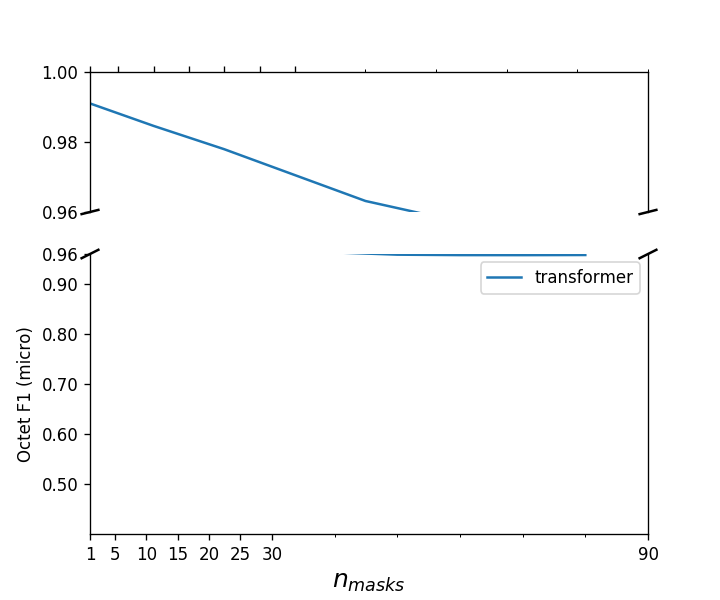

/zhome/9e/8/130993/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 0, '$n_{masks}$')

In [18]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet F1 (micro)')
#ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
#ax2.annotate('Bag-of-Atoms', xy=(4.5,0.53), xytext=(2.5,0.41),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
#ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})


colors = {'Unigram':'C5', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C1',
         'transformer':'C3',
         'transformer bond':'C4',
         'OctetRule':'C5'}

for key, group in results_mask['f1 micro (octet)'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2)

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.96, 1.00001])
ax2.set_ylim([0.4, 0.96])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_xticks([1,5,10,15,20,25,30,90])
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.96])
ax.get_legend().remove()
#ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
#plt.savefig('f1_micro_vs_nmask2.pdf')

<IPython.core.display.Javascript object>


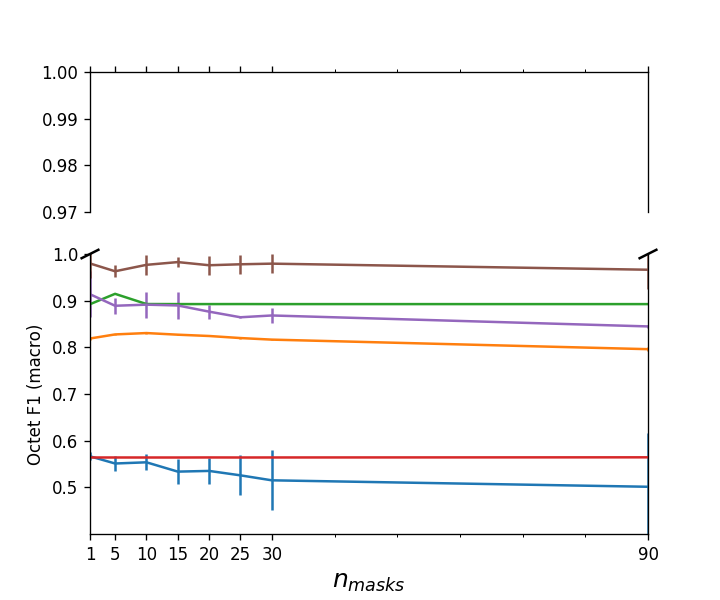

Text(0.5, 0, '$n_{masks}$')

In [37]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Octet F1 (macro)')
#ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
#ax2.annotate('Bag-of-Atoms', xy=(4.5,0.53), xytext=(2.5,0.41),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
#ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})


colors = {'Unigram':'C5', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C1',
         'transformer':'C3',
         'transformer bond':'C4',
         'OctetRule':'C5'}

for key, group in results_mask['f1 macro (octet)'].reset_index().groupby('model_name_short'):
    
    #group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2)

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.97, 1.00001])
ax2.set_ylim([0.4, 1])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
#ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_xticks([1,5,10,15,20,25,30,90])
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,1])
#ax.get_legend().remove()
ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
#plt.savefig('f1_micro_vs_nmask2.pdf')

<IPython.core.display.Javascript object>


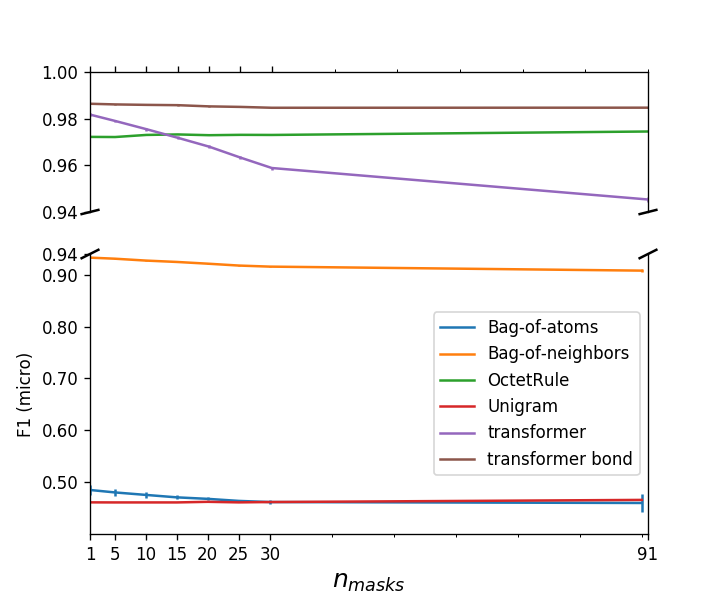

Text(0.5, 0, '$n_{masks}$')

In [40]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('F1 (micro)')
#ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
#ax2.annotate('Bag-of-Atoms', xy=(4.5,0.53), xytext=(2.5,0.41),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
#ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})


colors = {'Unigram':'C5', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C1',
         'transformer':'C3',
         'transformer bond':'C4',
         'OctetRule':'C5'}

for key, group in results_mask['f1 micro'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2)

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.94, 1.00001])
ax2.set_ylim([0.4, 0.94])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
ax2.set_xticks([1,5,10,15,20,25,30,91])
ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.94])
ax.get_legend().remove()
#ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
#plt.savefig('f1_micro_vs_nmask2.pdf')

<IPython.core.display.Javascript object>


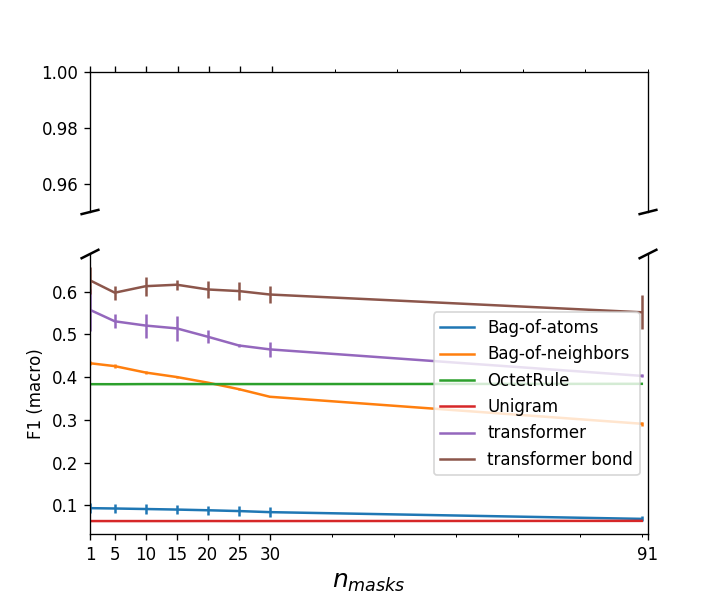

Text(0.5, 0, '$n_{masks}$')

In [42]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('F1 (macro)')
#ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
#ax2.annotate('Bag-of-Atoms', xy=(4.5,0.53), xytext=(2.5,0.41),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
#ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})


colors = {'Unigram':'C5', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C1',
         'transformer':'C3',
         'transformer bond':'C4',
         'OctetRule':'C5'}

for key, group in results_mask['f1 macro'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2)

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([0.95, 1.00001])
#ax2.set_ylim([0.4, 0.96])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.96])
ax2.set_xticks([1,5,10,15,20,25,30,91])
ax.get_legend().remove()
#ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
#plt.savefig('f1_micro_vs_nmask2.pdf')

<IPython.core.display.Javascript object>


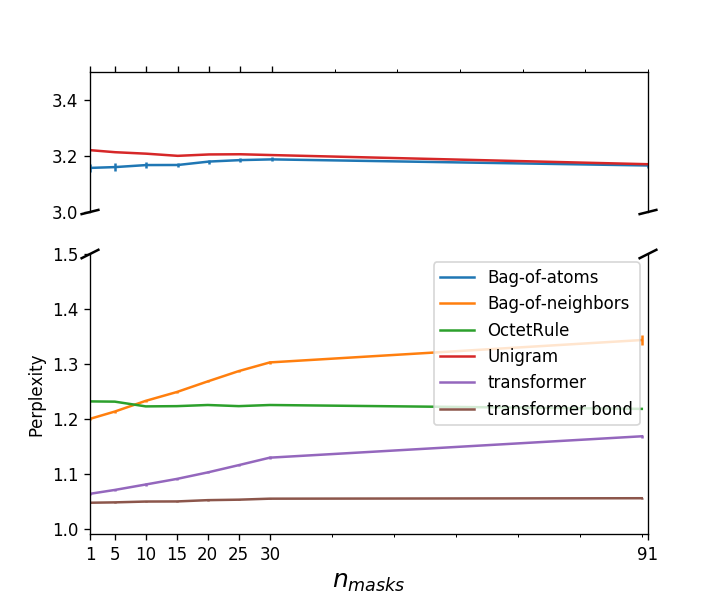

Text(0.5, 0, '$n_{masks}$')

In [51]:
fig, (ax, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,5), gridspec_kw={'height_ratios':[1,2]})
plt.ylabel('Perplexity')
#ax2.annotate('Unigram', xy=(17,0.48), xytext=(20,0.55),arrowprops={'arrowstyle':'->',})
#ax2.annotate('Bag-of-Atoms', xy=(4.5,0.53), xytext=(2.5,0.41),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbors', xy=(4.5,0.55), xytext=(3.1,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(3,0.98), xytext=(5,0.85),arrowprops={'arrowstyle':'->'})
#ax.annotate('Octet-Rule-Unigram', xy=(4,1), xytext=(6,1.00004),arrowprops={'arrowstyle':'->'})
#ax.annotate('Bond-Transformer', xy=(7,0.99995), xytext=(10,0.99985),arrowprops={'arrowstyle':'->'})


colors = {'Unigram':'C5', 
         'Bag-of-atoms':'C0',
         'Bag-of-neighbors':'C1',
         'transformer':'C3',
         'transformer bond':'C4',
         'OctetRule':'C5'}

for key, group in results_mask['pp'].reset_index().groupby('model_name_short'):
    
    group.plot('num_masks','mean',yerr='std', label=key, ax=ax)

    group.plot('num_masks','mean',yerr='std', label=key, ax=ax2)

#ax.set_xticks(np.arange(1,6, 1.0))
ax.set_ylim([3, 3.5])
ax2.set_ylim([0.99,1.5])

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#ax2.set_xlim([0.9, 5.1])
#ax2.set_xticks(np.arange(1,6, 1.0))
#ax2.set_yticks([0.5,0.6,0.7,0.8,0.9,0.96])
ax2.set_xticks([1,5,10,15,20,25,30,91])
ax.get_legend().remove()
#ax2.get_legend().remove()
ax2.set_xlabel('$n_{masks}$', fontsize=15)
#plt.savefig('f1_micro_vs_nmask2.pdf')

In [56]:
results_length

f1 micro            f1 macro            \
                             mean       std      mean       std   
model_name_short length                                           
OctetRule        13      0.800000       NaN  0.833333       NaN   
                 14      0.600000       NaN  0.315152       NaN   
                 15      0.880000       NaN  0.479167       NaN   
                 16      0.900000       NaN  0.733333       NaN   
                 17      0.950000       NaN  0.623529       NaN   
                 18      0.900000       NaN  0.720000       NaN   
                 19      0.937500       NaN  0.614550       NaN   
                 20      0.945455       NaN  0.545891       NaN   
                 21      0.926316       NaN  0.540248       NaN   
                 22      0.900000       NaN  0.445102       NaN   
                 23      0.922222       NaN  0.445810       NaN   
                 24      0.943860       NaN  0.421138       NaN   
                 25      0.929231       NaN  0.414179       NaN   
                 26      0.924490       NaN  0.461089       NaN   
                 27      0.929600       NaN  0.462521       NaN   
                 28      0.934969       NaN  0.455509       NaN   
                 29      0.925123       NaN  0.397762       NaN   
                 30      0.943210       NaN  0.462827       NaN   
                 31      0.948529       NaN  0.468321       NaN   
                 32      0.942175       NaN  0.461118       NaN   
                 33      0.953942       NaN  0.420398       NaN   
                 34      0.953434       NaN  0.419671       NaN   
                 35      0.961527       NaN  0.474136       NaN   
                 36      0.961449       NaN  0.473152       NaN   
                 37      0.960510       NaN  0.474267       NaN   
                 38      0.962613       NaN  0.476915       NaN   
                 39      0.968031       NaN  0.479191       NaN   
                 40      0.966195       NaN  0.477885       NaN   
                 41      0.963500       NaN  0.422202       NaN   
                 42      0.971018       NaN  0.425842       NaN   
...                           ...       ...       ...       ...   
transformer bond 49      0.989606  0.000520  0.669478  0.004767   
                 50      0.988613  0.000381  0.676401  0.005129   
                 51      0.991514  0.000316  0.660782  0.004302   
                 52      0.991110  0.000464  0.654510  0.002833   
                 53      0.991525  0.000411  0.663967  0.003129   
                 54      0.993148  0.000675  0.786710  0.004795   
                 55      0.992784  0.000271  0.743934  0.004637   
                 56      0.993823  0.000471  0.689126  0.004669   
                 57      0.993074  0.000490  0.767845  0.005852   
                 58      0.994068  0.000808  0.753336  0.010405   
                 59      0.993201  0.000661  0.890613  0.005038   
                 60      0.993304  0.001168  0.692440  0.008436   
                 61      0.992163  0.000803  0.686106  0.006646   
                 62      0.994179  0.000690  0.692649  0.006406   
                 63      0.990705  0.001093  0.656341  0.013139   
                 64      0.995385  0.000758  0.712481  0.001269   
                 65      0.993115  0.002015  0.824876  0.003234   
                 66      0.994286  0.001129  0.827032  0.001798   
                 67      0.994933  0.001968  0.984415  0.005781   
                 68      0.992593  0.003024  0.958017  0.034088   
                 69      0.999524  0.001506  0.998909  0.003452   
                 70      0.975238  0.004918  0.917197  0.012351   
                 71      0.988571  0.006023  0.964306  0.017420   
                 72      0.980000  0.000000  0.745098  0.000000   
                 73      1.000000  0.000000  1.000000  0.000000   
                 74      1.000000  0.000000  1.000000  0.000000   
     

<IPython.core.display.Javascript object>


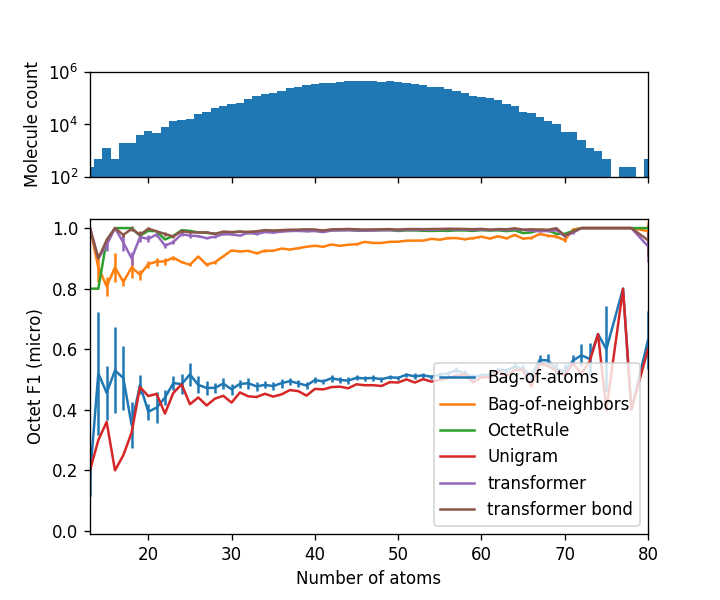

Text(0.5, 0, 'Number of atoms')

In [47]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax2.set_ylabel('Octet F1 (micro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length['f1 micro (octet)'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax2)
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e2,1e4,1e6])
ax2.set_xlabel('Number of atoms')
#plt.savefig('f1_micro_vs_length_5.pdf')

<IPython.core.display.Javascript object>


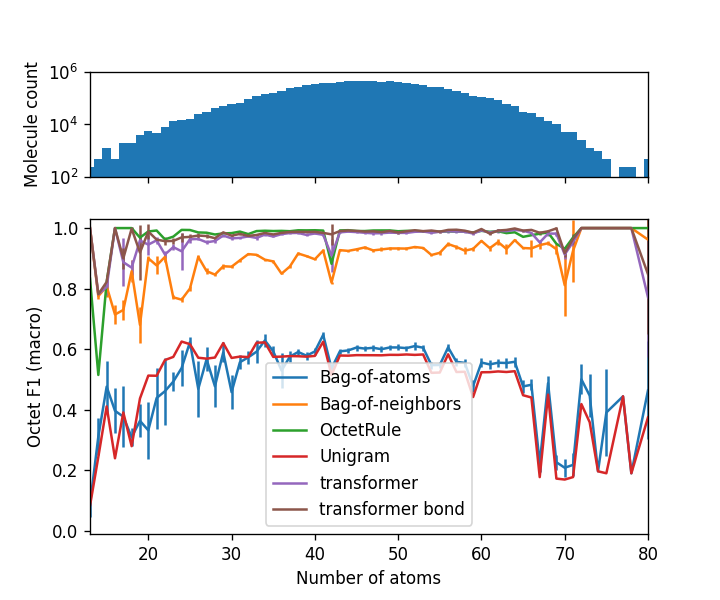

Text(0.5, 0, 'Number of atoms')

In [52]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax2.set_ylabel('Octet F1 (macro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length['f1 macro (octet)'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax2)
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e2,1e4,1e6])
ax2.set_xlabel('Number of atoms')
#plt.savefig('f1_micro_vs_length_5.pdf')

<IPython.core.display.Javascript object>


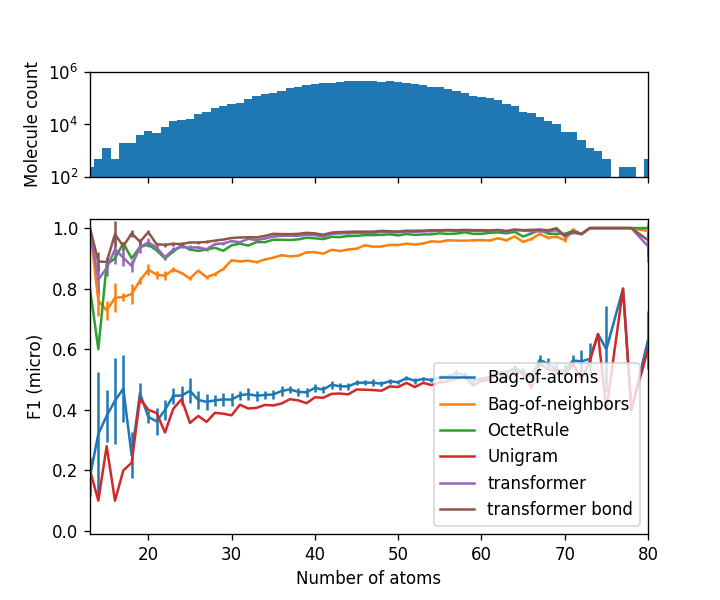

Text(0.5, 0, 'Number of atoms')

In [54]:
#results_df = df[df['num_masks']==5].groupby(['model_name', 'model_name_short','length']).apply(lambda df:pd.Series({'f1':f1_score(df.target, df.prediction, average='micro')})).groupby(['model_name_short', 'length']).agg(['mean','std'])
fig, (ax, ax2) = plt.subplots(2,1, sharex=True,figsize=(6,5), gridspec_kw={'height_ratios':[1,3]})
ax2.set_ylabel('F1 (micro)')
#ax2.annotate('Unigram', xy=(15,0.4), xytext=(15,0.2),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Atoms', xy=(16,0.49), xytext=(20,0.4),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bag-of-Neighbours', xy=(16,0.52), xytext=(15,0.75),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Binary-Transformer', xy=(10,0.8), xytext=(9,0.65),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Octet-Rule', xy=(5.5,1), xytext=(6,1.07),arrowprops={'arrowstyle':'->'})
#ax2.annotate('Bond-Transformer', xy=(6.5,0.96), xytext=(8,0.9),arrowprops={'arrowstyle':'->'})

for key, group in results_length['f1 micro'].reset_index().groupby('model_name_short'):
    group.plot('length','mean',yerr='std', label=key, ax=ax2)
    
#ax2.set_xticks(np.arange(5,28, 2.0))
#ax2.set_xlim([4, 28])
ax2.set_ylim([-0.01,1.03])
#ax2.get_legend().remove()

ax.hist(df[(df['num_masks']==5)]['length'], density=False, bins=np.arange(5,90)+0.5)
ax.set_ylabel('Molecule count')
ax.set_yscale('log')
ax.set_yticks([1e2,1e4,1e6])
ax2.set_xlabel('Number of atoms')
#plt.savefig('f1_micro_vs_length_5.pdf')

In [35]:
df[(df['num_masks']==5) & (df['model_name_short']=='Unigram')]['length'], density=False, bins=np.arange(5,28)+0.5)

AttributeError: module 'pandas' has no attribute 'histogram'

# per mask

In [96]:
df2 = pd.read_sql_query("""select count(*) as c ,atom as target, length 
                          from predictions, molecules, atoms
                          where 
                          predictions.molecule_id=molecules.molecule_id
                          and atoms.atom_id = predictions.target 
                          and model_id=1
                          and num_masks=1
                          group by target, length
                          """, conn)

<IPython.core.display.Javascript object>


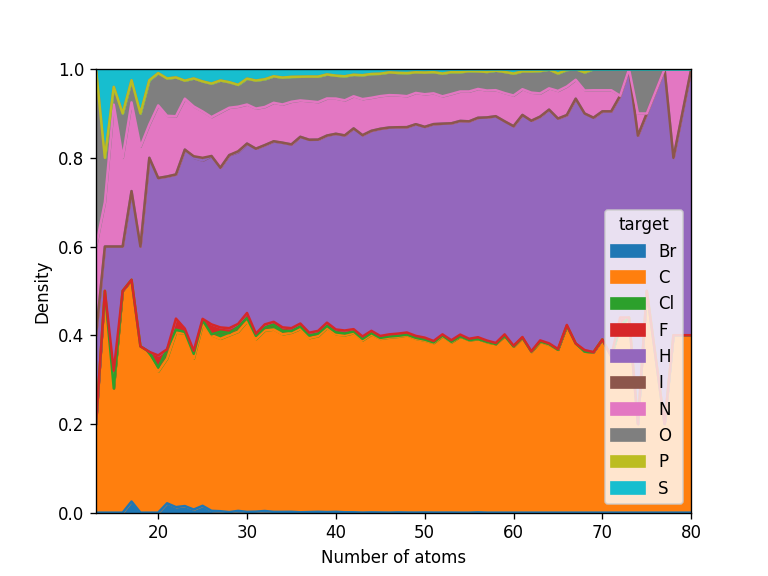

In [97]:
df3= df2.pivot(index='length', columns='target', values='c')
df3.div(df3.sum(axis=1), axis=0).plot.area()
plt.ylabel('Density')
plt.xlabel('Number of atoms')
plt.ylim([0,1])
#plt.xticks(np.arange(5,28,2))
plt.savefig('distribution_length_unique.pdf')

<IPython.core.display.Javascript object>


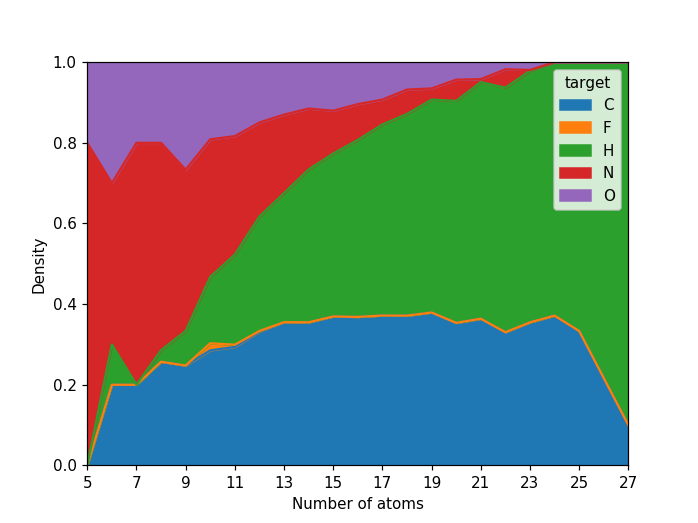

In [43]:
df3= df2.pivot(index='length', columns='target', values='c')
df3.div(df3.sum(axis=1), axis=0).plot.area()
plt.ylabel('Density')
plt.xlabel('Number of atoms')
plt.ylim([0,1])
plt.xticks(np.arange(5,28,2))
plt.savefig('fdistribution_length_5.pdf')

In [39]:
from utils.dataloader import QM9Dataset, DataLoader

In [92]:
d = QM9Dataset(data='data/zinc/adjacency_matrix_test_scaffold.pkl',num_masks=50)
dl = DataLoader(d,batch_size=100)

In [93]:
all_atoms = []
for b in iter(dl):
    for atoms in b.targets:
        for atom in atoms:
            all_atoms.append(atom)

In [94]:
from collections import Counter

In [95]:
c=Counter(all_atoms)
c

Counter({'C': 659033,
         'O': 82896,
         'N': 120700,
         'H': 773799,
         'S': 17015,
         'Cl': 4578,
         'F': 7766,
         'Br': 1000,
         'I': 35,
         'P': 16})

In [75]:
c['H']/(c['H']+c['F'])

0.99653530012378

In [76]:
c['F']/(c['H']+c['F'])

0.003464699876219975

<IPython.core.display.Javascript object>


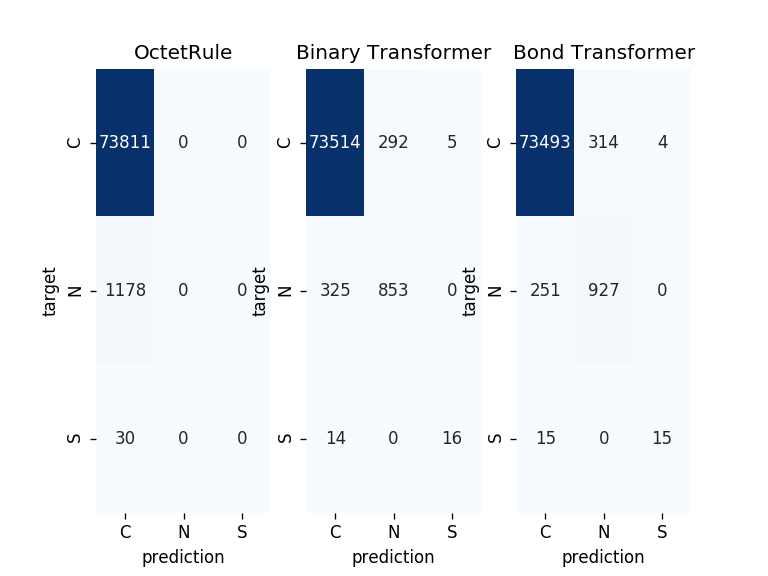

In [9]:
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3)
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==4]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique())))) 
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])

<IPython.core.display.Javascript object>


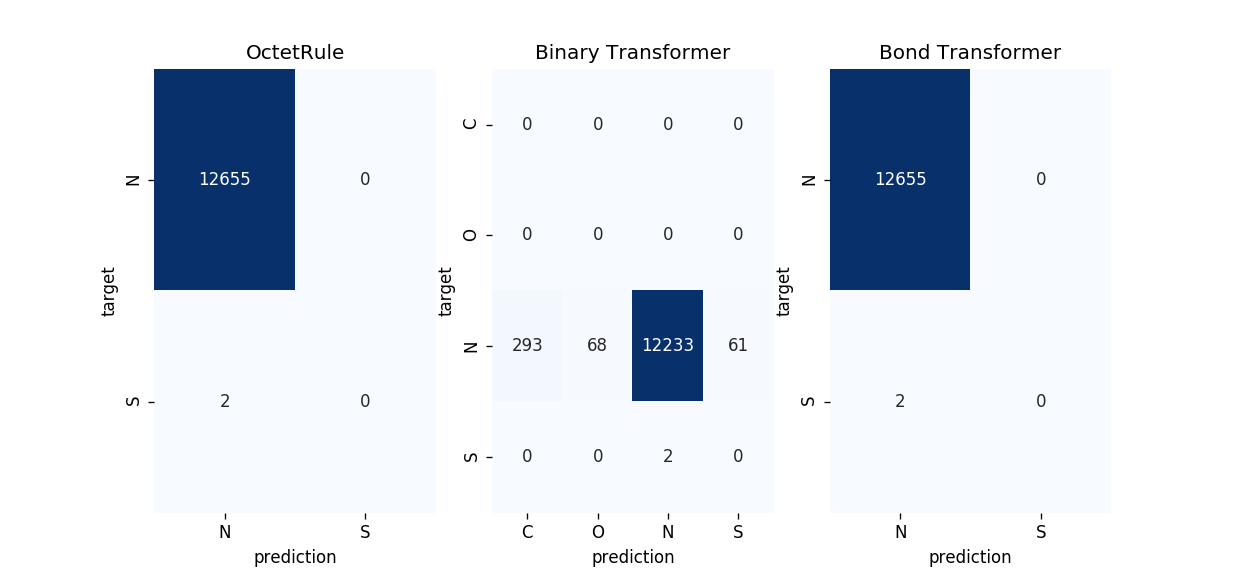

In [120]:
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3)
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==3]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique())))) 
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])

<IPython.core.display.Javascript object>


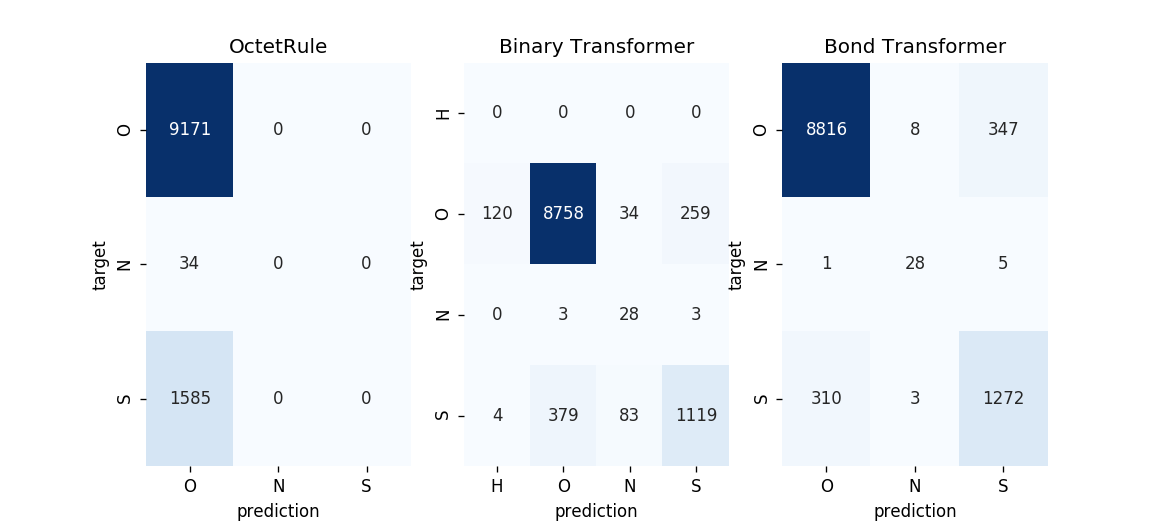

In [121]:
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3)
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==2]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique()))))
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])

<IPython.core.display.Javascript object>


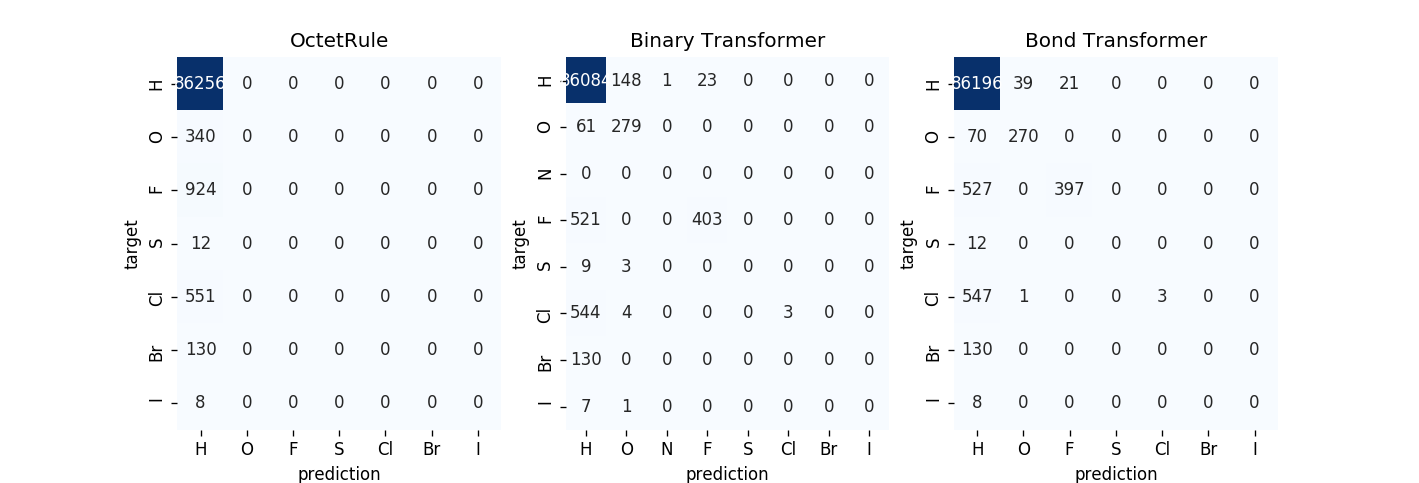

In [122]:
conn = sqlite3.connect("/work1/s180213/results_zinc_3.db")
models = [3,1,2]
model_names = ['OctetRule','Binary Transformer','Bond Transformer']
fig, ax = plt.subplots(1,3)
for i,model in enumerate(models):
    df = pd.read_sql_query(f"""select

                        prediction,
                        target,
                        charge,
                        num_neighbours,
                        atom
                              from predictions, atoms
                              where
                              model_id ={model}
                              and num_masks=1
                              and predictions.prediction=atoms.atom_id

                               """, conn)
    df4 = df[df.num_neighbours==1]

    labels = sorted(list(set(list(df4['target'].unique())+ list(df4['prediction'].unique()))))
    cf=confusion_matrix(df4['target'],df4['prediction'],labels=labels)
    
    sn.heatmap(cf, annot=True, cmap="Blues",fmt='g',cbar=False, ax=ax[i])
    ax[i].xaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].yaxis.set_ticklabels([int2atom[l+1] for l in labels])
    ax[i].set_xlabel('prediction')
    ax[i].set_ylabel('target')
    ax[i].set_title(model_names[i])

In [112]:
df[df.num_neighbours==3]['target'].unique()

array([3, 6])

In [28]:

confusion_matrix(df4['target'],df4['prediction'],labels=sorted(df4['prediction'].unique()))

array([[    0,     0,     0,     0,     0],
       [    0, 73456,     0,   352,     3],
       [    0,     0,     0,     0,     0],
       [    0,   318,     0,   860,     0],
       [   15,    12,   451,   102,  1456]])

<IPython.core.display.Javascript object>


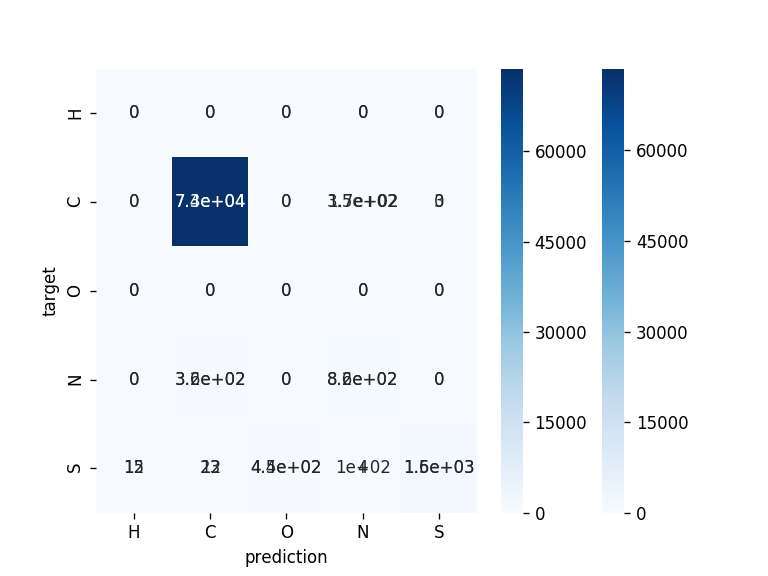

Text(50.722222222222214, 0.5, 'target')

In [37]:
import seaborn as sn
plt.figure()
ax= sn.heatmap(confusion_matrix(df['target'],df['prediction'],labels=sorted(df['prediction'].unique())), annot=True, cmap="Blues")
ax.xaxis.set_ticklabels(['H','C','O','N','S'])
ax.yaxis.set_ticklabels(['H','C','O','N','S'])
ax.set_xlabel('prediction')
ax.set_ylabel('target')